# Exploring airline reviews using NLP models


In this notebook, we will import packages, read and clean data and perform the sentiment analyses using NLP modules in Python. We will also evaluate the performance of these modules. The following four NLP models are considered:
  - **TextBlob** 
  - **VADER** (Valence Aware Dictionary and sEntiment Reasoner)
  - **RoBERTa** - pretrained model, including Huggingface pipeline
  - **Flair framework** - Read more information [here](https://github.com/flairNLP/flair).

## 1. Import packages

In [4]:
# Lets install Python packages required for our analysis
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests as rq
import os
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")


import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

from textblob import TextBlob
from tqdm.notebook import tqdm #Progress bar tracker for looped processing below

# pip install transformers vaderSentiment

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## 2. Read and join datasets

In [5]:
# Import and read datasets from the path
path = r'/content/drive/MyDrive/Colab Notebooks/airline/' 

# Access all CSVs in the folder 
files = Path(path).glob('*.csv') 


dfs = list()
for f in files:
  data = pd.read_csv(f)
  data['file'] = f.stem   # .stem method is used to get the filename only and not the extension
  dfs.append(data)

df = pd.concat(dfs, ignore_index=True)
df = df.rename(columns={"file":"airline"})


In [6]:
df.head(5)
df["airline"].value_counts()

Ryanair            450
Lufthansa          360
British Airways    270
Air France         180
Name: airline, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           1260 non-null   object 
 1   aircraft         527 non-null    object 
 2   travel_type      1257 non-null   object 
 3   travel_class     1260 non-null   object 
 4   route            1260 non-null   object 
 5   date             1260 non-null   object 
 6   seating_comfort  1202 non-null   float64
 7   staff_service    1190 non-null   float64
 8   food_quality     1014 non-null   float64
 9   entertainment    806 non-null    float64
 10  wifi             529 non-null    float64
 11  ground_service   1241 non-null   float64
 12  value_for_money  1260 non-null   int64  
 13  recommended      1260 non-null   object 
 14  overall_rating   1260 non-null   int64  
 15  review           1260 non-null   object 
 16  airline          1260 non-null   object 
dtypes: float64(6),

## 3. Explore the data

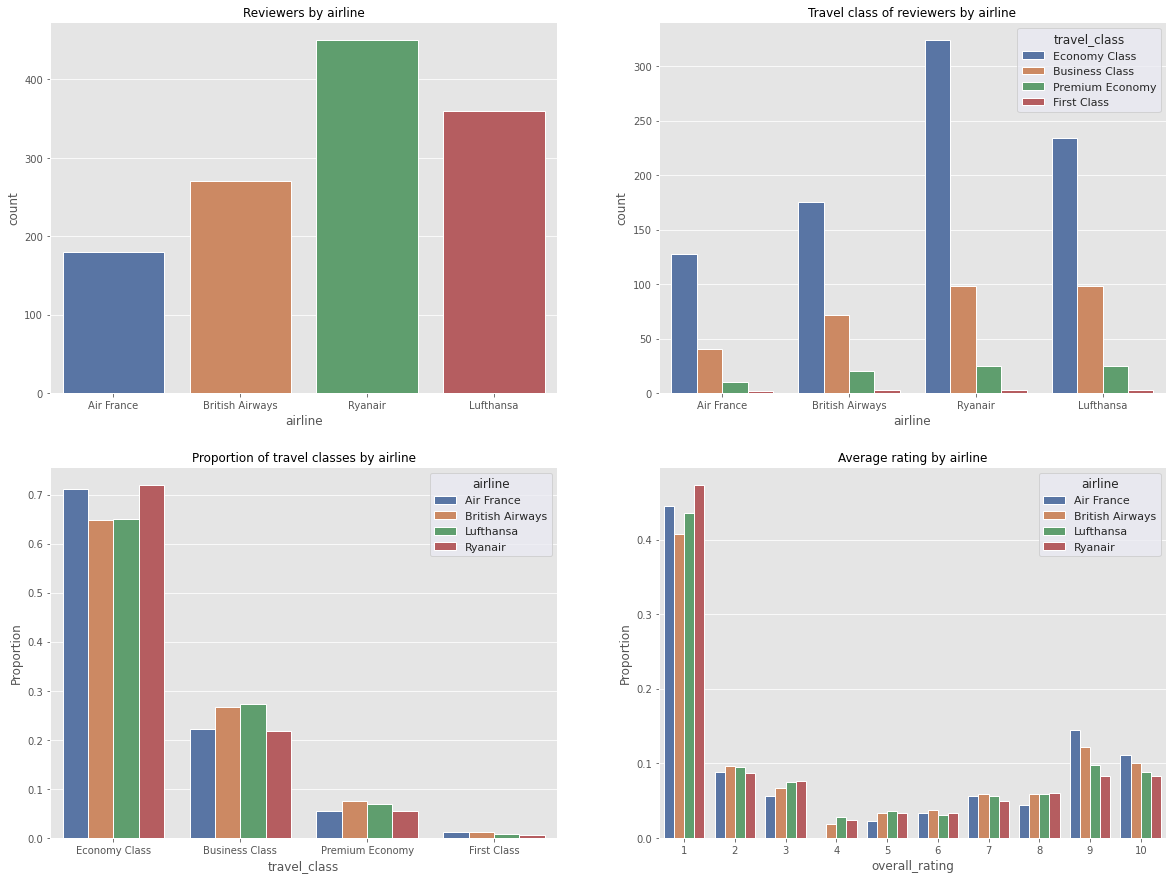

In [8]:
# Let's visualize the data, especially the reviewer-airline relationship and reviewer ratings

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
sns.set()
sns.countplot(data=df, x="airline", ax=axs[0, 0]).set(title='Reviewers by airline')
sns.countplot(data=df, x="airline", hue="travel_class", ax=axs[0, 1]).set(title='Travel class of reviewers by airline')
x, y, hue = "travel_class", "Proportion", "airline"
df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ax=axs[1, 0]).set(title='Proportion of travel classes by airline')
x, y, hue = "overall_rating", "Proportion", "airline"
df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ax=axs[1, 1]).set(title='Average rating by airline')
plt.show()

We also have reviewers' ratings on distinct facilities and services provided by the airlines. Let's fish whether we observe any heterogeneities that simiple eyeballing deems important. 

[Text(0.5, 1.0, 'Other comfort')]

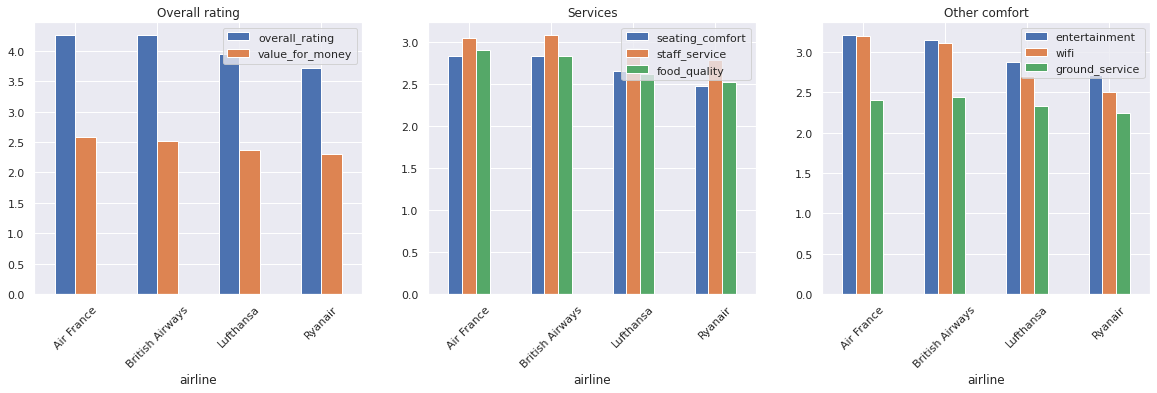

In [9]:
# First we plot overall ratings for the airline and whether customers think that the money spent was well spent.  

fig, axs = plt.subplots(1,3, figsize = (20, 5))
df.groupby('airline')[['overall_rating','value_for_money']].mean().plot(kind='bar', rot=45, ax = axs[0]).set(title="Overall rating")
# Reviewer ratings on seating comfort, staff service and food quality
df.groupby('airline')[['seating_comfort','staff_service', 'food_quality']].mean().plot(kind='bar', rot=45, ax = axs[1]).set(title="Services")
# Reviewer ratings on general entertainment, Wifi and ground services
df.groupby('airline')[['entertainment','wifi', 'ground_service']].mean().plot(kind='bar', rot=45, ax = axs[2]).set(title="Other comfort")


# # # We can also plot distribution plot as shown here
# # results_df.groupby('airline')['wifi'].plot(kind='kde', ax = axs[1])
# # plt.legend(title='Airlines')
# # plt.xlabel('wifi ratings')


## 4. Extract sentiments from customer reviews
We will now employ available Python modules for extracting sentiments (and imp insights) from review texts. Let's check an example review text, we will come back to it later.

In [10]:
df["review"].values[0]
example = df["review"][0]
print(example)

  I arrived to Palma de Mallorca, Spain from San Francisco, California on September 23rd, 2022. I filed my missing baggage claim on the 30th of September, 2022 and presented receipts for some of the articles I had replaced within that time frame between my arrival and my request for compensation. I was awarded the money compensation I applied for and the Air France Customer Care Assistance said they would have the money wired to my bank account over the next several weeks. I haven't seen a penny of the compensation. I called Air France Spain yesterday and the representative reopened the claim for investigation into whether or not the payment was initiated or not or if I may need to provide additional bank account information. Instead of further investigation or engagement with me, I received and email stating that the claim was handled "correctly" and that no further correspondence with me would be continued based on this topic. So, in the end, I have received no compensation I was tol

### **I. TextBlob**
This sentiment analyzer returns two properties of the inputted text: 
1. **Polarity**: It is a score that indicates the mood state of the word, i.e., negative/neutral/positive mood. It varies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments. 
2. **Subjectivity**: Indicates the the extent of using opinionated/judgemental words in the sentence. It is a score ranging betweem 0 and 1, indicating increasing subjectivity from 0 to 1.

In [11]:
# Lets apply TextBlob on the example sentence
example_tb = TextBlob(example)
print(example_tb.sentiment)
# TextBlob polarity score indicates that the review is close to neutral/positive. But upon reading, it is clear that it is written by a disgruntled reviewer who is completely unhappy.

# for fun try other examples:
# example_tb = TextBlob("I hate you")
# print(example_tb.sentiment)
# print(example) 

Sentiment(polarity=0.022222222222222216, subjectivity=0.38277777777777783)


In [12]:
print(example)
example_tb = TextBlob(example)
print(example_tb.sentiment)

  I arrived to Palma de Mallorca, Spain from San Francisco, California on September 23rd, 2022. I filed my missing baggage claim on the 30th of September, 2022 and presented receipts for some of the articles I had replaced within that time frame between my arrival and my request for compensation. I was awarded the money compensation I applied for and the Air France Customer Care Assistance said they would have the money wired to my bank account over the next several weeks. I haven't seen a penny of the compensation. I called Air France Spain yesterday and the representative reopened the claim for investigation into whether or not the payment was initiated or not or if I may need to provide additional bank account information. Instead of further investigation or engagement with me, I received and email stating that the claim was handled "correctly" and that no further correspondence with me would be continued based on this topic. So, in the end, I have received no compensation I was tol

In [13]:
def sentiment_analysis(df):
  def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
  #Create a function to get the polarity
  def getPolarity(text):
    return TextBlob(text).sentiment.polarity
  #Create two new columns ‘Subjectivity’ & ‘Polarity’
  df["subjectivity_tb"] =    df["review"].apply(getSubjectivity)
  df ["polarity_tb"] = df["review"].apply(getPolarity)
  def getAnalysis(score):
    if score < 0:         # Am not very comfortable with this threshold, but fine for the demonstration purpose!
      return "Negative"
    elif score == 0:
      return "Neutral"
    else:
      return "Positive"
  df["sentiment_tb"] = df["polarity_tb"].apply(getAnalysis)
  return df
# We call the function and store scores in our df  
sentiment_analysis(df)

# Alternatively, one can simply run the following command to store polarity and subjectivity scores. 
# df[["polarity", "subjectivity"]] = df["review"].apply(lambda Text:pd.Series(TextBlob(Text).sentiment))
# And chose the thresholds of your choice or comfort

,status,aircraft,travel_type,travel_class,route,date,seating_comfort,staff_service,food_quality,entertainment,wifi,ground_service,value_for_money,recommended,overall_rating,review,airline,subjectivity_tb,polarity_tb,sentiment_tb
0,✅ Trip Verified,NaN,Solo Leisure,Economy Class,San Francisco to Palma de Mallorca via Paris,September 2022,3.0,3.0,4.0,5.0,NaN,3.0,3,no,3,"I arrived to Palma de Mallorca, Spain from S...",Air France,0.382778,0.022222,Positive
1,Not Verified,A350,Solo Leisure,Economy Class,Chicago to Paris,November 2022,4.0,4.0,3.0,4.0,3.0,3.0,4,yes,7,The plane was nice. IFE was pretty good. The...,Air France,0.413099,0.148657,Positive
2,✅ Trip Verified,A320 / Boeing 777-200,Solo Leisure,Business Class,Manchester to Bangkok via Paris,November 2022,3.0,5.0,5.0,4.0,NaN,4.0,5,yes,9,The Manchester to Paris segment was very ave...,Air France,0.550000,0.182727,Positive
3,✅ Trip Verified,Boeing 777-200ER,Business,Economy Class,Paris to Miami,November 2022,4.0,5.0,4.0,5.0,5.0,4.0,5,yes,10,Glitch with agent put me in regular window s...,Air France,0.437738,0.090727,Positive
4,✅ Trip Verified,Boeing 777,Solo Leisure,Business Class,Mexico City to Paris,November 2022,2.0,5.0,5.0,5.0,4.0,4.0,5,yes,8,Wonderful flight. Extremely professional cre...,Air France,0.620000,0.480000,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,✅ Trip Verified,NaN,Family Leisure,Economy Class,Rome to Munich,September 2022,1.0,1.0,1.0,1.0,1.0,1.0,1,no,1,This is the worst international airline I ha...,Lufthansa,0.550000,-0.115625,Negative
1256,✅ Trip Verified,NaN,Business,Economy Class,Munich to Tel Aviv,September 2022,1.0,1.0,1.0,2.0,NaN,1.0,1,no,1,4 hours flight from Munich to Tel Aviv I pai...,Lufthansa,0.350000,0.062500,Positive
1257,✅ Trip Verified,NaN,Couple Leisure,Economy Class,Denver to Istanbul via Frankfurt,September 2022,1.0,3.0,1.0,3.0,3.0,3.0,1,no,3,Denver to Istanbul via Frankfurt. We flew Lu...,Lufthansa,0.565873,-0.116567,Negative
1258,✅ Trip Verified,NaN,Solo Leisure,Economy Class,Frankfurt to Seoul,September 2022,2.0,1.0,1.0,2.0,2.0,1.0,1,no,3,I was traveling on round trip from Seoul to ...,Lufthansa,0.441190,0.150000,Positive


In [14]:
print(df["sentiment_tb"].value_counts())
# A majority of reviews report positive sentiments

# Check how polarity scores perform in relation to overall ratings
tb_mean = df.groupby('overall_rating')[['polarity_tb', "subjectivity_tb"]].mean()
print(tb_mean)

# We can also do this by sentiment categories 
tb_mean2 = df.groupby('sentiment_tb')[['overall_rating', "subjectivity_tb"]].mean()
print(tb_mean2)

# We make two observations: 
# 1. Positive relationship between overall ratings and the polarity scores.
# 2. Polarity scores of the negative sentiment reviews (overall rating 1) are not too negative, indicating TextBlob's inability to discriminate the context and valence often importantly present in user reviews.

Positive    783
Negative    458
Neutral      19
Name: sentiment_tb, dtype: int64
                polarity_tb  subjectivity_tb
overall_rating                              
1                 -0.018832         0.442266
2                 -0.029691         0.482279
3                 -0.015123         0.480122
4                  0.036826         0.513688
5                  0.008474         0.446052
6                  0.075019         0.488761
7                  0.113436         0.450248
8                  0.264963         0.538602
9                  0.266865         0.564008
10                 0.252362         0.552287
              overall_rating  subjectivity_tb
sentiment_tb                                 
Negative            1.770742         0.452670
Neutral             3.526316         0.100987
Positive            5.275862         0.505925


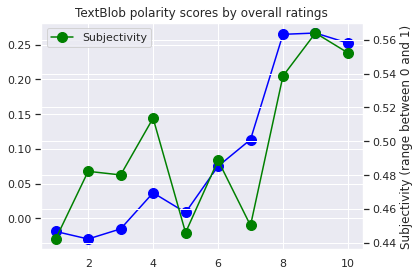

In [15]:
# Alternatively, visualize the TextBlob results against self-reported user ratings
fig = plt.figure()
ax = fig.add_subplot(221)
bench_by_size = df.groupby('overall_rating')
means = bench_by_size.mean()

ax1 = plt.subplot()
l1=plt.plot(means['polarity_tb'],  color='blue', linestyle='-', marker='o', markersize=10, label = 'Polarity')
ax.set_ylabel(r"Polarity (range between -1 and 1)")

ax2 = ax1.twinx()
l2=plt.plot(means["subjectivity_tb"],  color='green', linestyle='-', marker='o', markersize=10, label = 'Subjectivity')
ax2.set_ylabel(r"Subjectivity (range between 0 and 1)")

ax.set_xlabel("Overall ratings")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_title("TextBlob polarity scores by overall ratings")
plt.tight_layout()
plt.show()

**Two observations:**
1. Polarity scores vary between -0.05 to 0.25. Majority of the reviews have scores near to weakly positive, and hence, are mildly positive/neutral in their emotional valence. However, upon reading one can conclude that this is not true. 
2. The reviews are highly subjective (>0.45) and more importantly, subjectivity does not differ much against ratings.

**Conclusion:** TextBlob polarity scores are not effective in discrimination information and emotions present in the user reviews.  

### **II. VADER** (Valence Aware Dictionary and sEntiment Reasoner) method 

VADER is a *lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media*.[[3]](#3)
- Bag of words approach to sentiment analysis: 
    1. it first removes stop words, 
    2. scores each word and then combines the scores 

In [16]:
# Need an id variable to save polarity scores of the individual text
df['Id'] = np.arange(df.shape[0])

# Let's call the SIA object
sia = SentimentIntensityAnalyzer()

In [17]:
# We can run the SIA on our example review to test its effectiveness 
# sia.polarity_scores("I am not very good good")
# output: {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
sia.polarity_scores(example)

{'neg': 0.051, 'neu': 0.906, 'pos': 0.043, 'compound': -0.3112}

In [18]:
# Like TextBlob, VADER also relies too much on words and ignores the context and sarcasm, etc. 
# For example, the following sentences have positive connotation and are denoted to have negative sentiment by TextBlob and VADER.
print(sia.polarity_scores("the party was savage"))
print(sia.polarity_scores("On your best day you're not as smart as I am on my worst day"))

print(TextBlob("the party was savage").sentiment)
print(TextBlob("On your best day you're not as smart as I am on my worst day").sentiment)


{'neg': 0.39, 'neu': 0.26, 'pos': 0.351, 'compound': -0.0772}
{'neg': 0.282, 'neu': 0.532, 'pos': 0.186, 'compound': -0.2865}
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.0714285714285714, subjectivity=0.6476190476190476)


In [19]:
# Lets run the polarity score on our dataframe
results_vader = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row["review"]
  myid = row["Id"]
  results_vader[myid] = sia.polarity_scores(text)

  0%|          | 0/1260 [00:00<?, ?it/s]

In [20]:
# Now we have sentiment scores in a dictionary "results_vader"
results_vader

# Let's convert this dictionary into a dataframe
vaders = pd.DataFrame(results_vader).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")
vaders.head()

,Id,neg,neu,pos,compound,status,aircraft,travel_type,travel_class,route,...,wifi,ground_service,value_for_money,recommended,overall_rating,review,airline,subjectivity_tb,polarity_tb,sentiment_tb
0,0,0.051,0.906,0.043,-0.3112,✅ Trip Verified,NaN,Solo Leisure,Economy Class,San Francisco to Palma de Mallorca via Paris,...,NaN,3.0,3,no,3,"I arrived to Palma de Mallorca, Spain from S...",Air France,0.382778,0.022222,Positive
1,1,0.071,0.762,0.167,0.9573,Not Verified,A350,Solo Leisure,Economy Class,Chicago to Paris,...,3.0,3.0,4,yes,7,The plane was nice. IFE was pretty good. The...,Air France,0.413099,0.148657,Positive
2,2,0.049,0.702,0.249,0.9831,✅ Trip Verified,A320 / Boeing 777-200,Solo Leisure,Business Class,Manchester to Bangkok via Paris,...,NaN,4.0,5,yes,9,The Manchester to Paris segment was very ave...,Air France,0.550000,0.182727,Positive
3,3,0.031,0.835,0.135,0.9430,✅ Trip Verified,Boeing 777-200ER,Business,Economy Class,Paris to Miami,...,5.0,4.0,5,yes,10,Glitch with agent put me in regular window s...,Air France,0.437738,0.090727,Positive
4,4,0.060,0.720,0.220,0.6971,✅ Trip Verified,Boeing 777,Solo Leisure,Business Class,Mexico City to Paris,...,4.0,4.0,5,yes,8,Wonderful flight. Extremely professional cre...,Air France,0.620000,0.480000,Positive


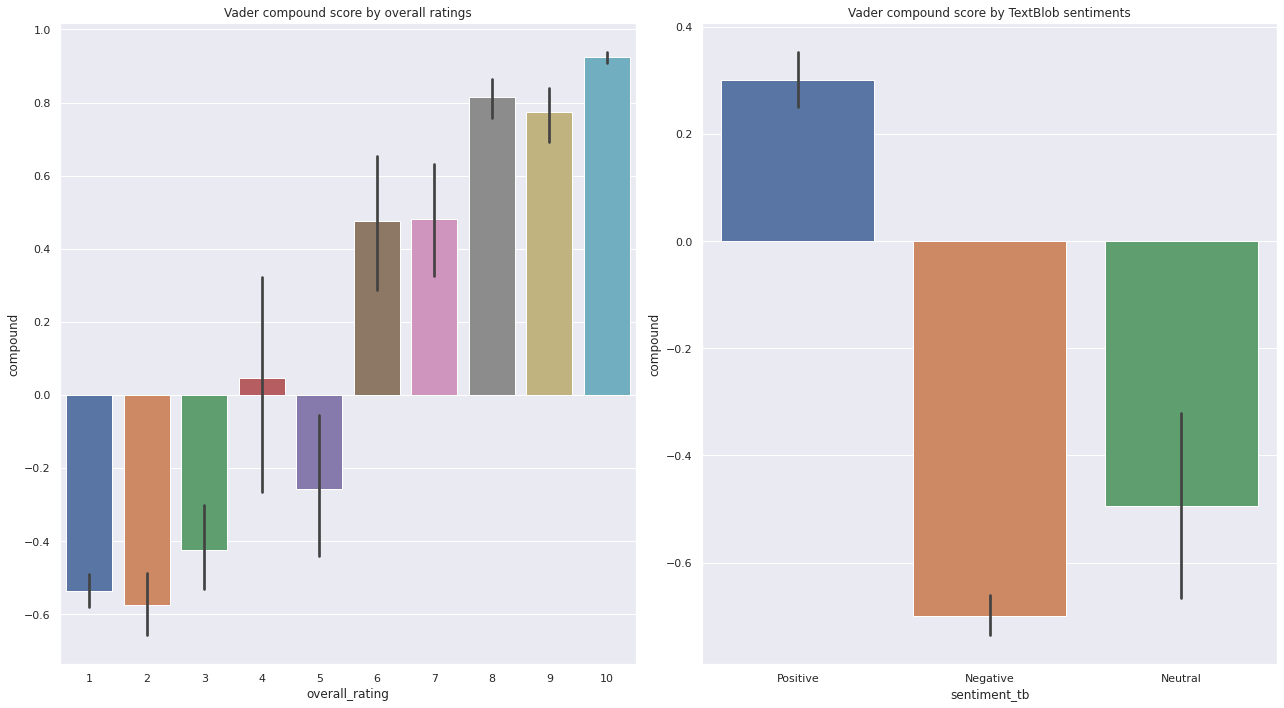

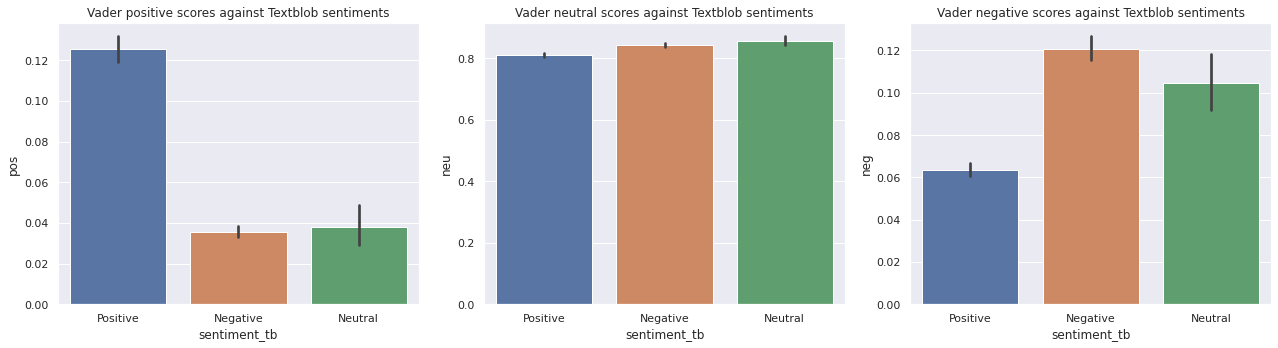

In [21]:
fig, axs = plt.subplots(1,2, figsize = (18, 10))
ax1, ax2 = axs.flatten()
sns.barplot(data = vaders, x="overall_rating",y="compound", ax = ax1)
sns.barplot(data = vaders, x="sentiment_tb",y="compound", ax = ax2)
ax1.set_title("Vader compound score by overall ratings")
ax2.set_title("Vader compound score by TextBlob sentiments")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize = (18, 5))
ax1, ax2, ax3 = axs.flatten()
sns.barplot(data = vaders, x="sentiment_tb",y="pos", ax = ax1)
sns.barplot(data = vaders, x="sentiment_tb",y="neu", ax = ax2)
sns.barplot(data = vaders, x="sentiment_tb",y="neg", ax = ax3)
ax1.set_title("Vader positive scores against Textblob sentiments")
ax2.set_title("Vader neutral scores against Textblob sentiments")
ax3.set_title("Vader negative scores against Textblob sentiments")
plt.tight_layout()
plt.show()

### **III. RoBERTa - Hugging Face**
- A pretrained model from Huggin Face - transfer learning for our data
- In addition to words, it also considers the *context* of the reviews (relationship between words), which VADER model fails to account for.

In [22]:
# Let's load the model that trained on Twitter comments 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# VADER results on example
print(example)
sia.polarity_scores(example)

# Run for RoBERTa model
# encoded_text = tokenizer(example, return_tensors="pt")
# output = model(**encoded_text)
# scores = output[0][0].detach().numpy()
# scores = softmax(scores)
# scores_dict = {
#     "roberta_neg": scores[0],
#     "roberta_neu":scores[1],
#     "roberta_pos":scores[2]
# }
# print(scores_dict)

def polarity_scores_roberta(example):

  encoded_text = tokenizer(example, return_tensors="pt")
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {"roberta_neg": scores[0], "roberta_neu": scores[1], "roberta_pos": scores[2]}
  return scores_dict


results_roberta = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row["review"]
    myid = row["Id"]
    vader_result=sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    results_roberta[myid] = both
  except RuntimeError:
    print(f"Broke for id {myid}")


results_df = pd.DataFrame(results_roberta).T
results_df = results_df.reset_index().rename(columns={"index": "Id"})
results_df = results_df.merge(df, how="left")
results_df.columns

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

  I arrived to Palma de Mallorca, Spain from San Francisco, California on September 23rd, 2022. I filed my missing baggage claim on the 30th of September, 2022 and presented receipts for some of the articles I had replaced within that time frame between my arrival and my request for compensation. I was awarded the money compensation I applied for and the Air France Customer Care Assistance said they would have the money wired to my bank account over the next several weeks. I haven't seen a penny of the compensation. I called Air France Spain yesterday and the representative reopened the claim for investigation into whether or not the payment was initiated or not or if I may need to provide additional bank account information. Instead of further investigation or engagement with me, I received and email stating that the claim was handled "correctly" and that no further correspondence with me would be continued based on this topic. So, in the end, I have received no compensation I was tol

  0%|          | 0/1260 [00:00<?, ?it/s]

Broke for id 41
Broke for id 81
Broke for id 131
Broke for id 171
Broke for id 221
Broke for id 261
Broke for id 311
Broke for id 351
Broke for id 437
Broke for id 491
Broke for id 531
Broke for id 581
Broke for id 621
Broke for id 707
Broke for id 721
Broke for id 729
Broke for id 747
Broke for id 756
Broke for id 777
Broke for id 789
Broke for id 824
Broke for id 941
Broke for id 981
Broke for id 1031
Broke for id 1071
Broke for id 1157
Broke for id 1171
Broke for id 1179
Broke for id 1197
Broke for id 1206
Broke for id 1227
Broke for id 1239


Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'status', 'aircraft',
       'travel_type', 'travel_class', 'route', 'date', 'seating_comfort',
       'staff_service', 'food_quality', 'entertainment', 'wifi',
       'ground_service', 'value_for_money', 'recommended', 'overall_rating',
       'review', 'airline', 'subjectivity_tb', 'polarity_tb', 'sentiment_tb'],
      dtype='object')

In [23]:
# Lets categorize VADER results into positive/negative/neutral sentiments
def vader_senti(row):
    if row['vader_compound'] >= 0.05:
        return "Positive"
    elif row['vader_compound'] <= 0.05:
        return "Negative"
    else:
        return "Neutral"
results_df['sentiment_vader'] = results_df.apply(vader_senti, axis=1)

# Lets categorize RoBERTa results into positive/negative/neutral sentiments
# First, we create variables indicating differences betweeen roberta scores
results_df['pos_neg_rob'] = results_df.apply(lambda row: row["roberta_pos"] - row["roberta_neg"], axis=1)
results_df['pos_neu_rob'] = results_df.apply(lambda row: row["roberta_pos"] - row["roberta_neu"], axis=1)
results_df['neg_pos_rob'] = results_df.apply(lambda row: row["roberta_neg"] - row["roberta_pos"], axis=1)
results_df['neg_neu_rob'] = results_df.apply(lambda row: row["roberta_neg"] - row["roberta_neu"], axis=1)

# Then we use a function rob_senti to create the sentiment_rob 
def rob_senti(row):
    if row['pos_neg_rob'] > 0 and row['pos_neu_rob'] > 0:
        return "Positive"
    elif row['neg_pos_rob'] > 0 and row["neg_neu_rob"] > 0:
        return "Negative"
    else:
        return "Neutral"
results_df['sentiment_rob'] = results_df.apply(rob_senti, axis=1)

results_df=results_df.drop(columns=["pos_neg_rob", "pos_neu_rob", "neg_pos_rob", "neg_neu_rob"])

### **IV. Flair**
Flair is a very easy to implement framework that can be used to perform state-of-the-art NLP. For more information, see the [source material](https://github.com/flairNLP/flair). 

In [27]:
from flair.models import TextClassifier
from flair.data import Sentence

from flair.models import TextClassifier
classifier = TextClassifier.load('sentiment-fast')
# Import flair Sentence to process input text
from flair.data import Sentence


# Define a function to get Flair sentiment prediction score
def score_flair(text):
  sentence = Sentence(text)
  classifier.predict(sentence)
  score = sentence.labels[0].score
  value = sentence.labels[0].value
  return score, value

# Get sentiment score for each review
results_df['scores_flair'] = results_df['review'].apply(lambda s: score_flair(s)[0])
# Predict sentiment label for each review
results_df['sentiment_flair'] = results_df['review'].apply(lambda s: score_flair(s)[1])
# Check the distribution of the score
results_df['scores_flair'].describe()
# Flair scores are almost near to 1 for most reviews, suggesting that our model is confident about its predictions.

2022-12-28 12:28:55,562 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


count    1228.000000
mean        0.970840
std         0.079118
min         0.507935
25%         0.987964
50%         0.999317
75%         0.999913
max         0.999999
Name: scores_flair, dtype: float64

In [28]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'status', 'aircraft',
       'travel_type', 'travel_class', 'route', 'date', 'seating_comfort',
       'staff_service', 'food_quality', 'entertainment', 'wifi',
       'ground_service', 'value_for_money', 'recommended', 'overall_rating',
       'review', 'airline', 'subjectivity_tb', 'polarity_tb', 'sentiment_tb',
       'sentiment_vader', 'sentiment_rob', 'scores_flair', 'sentiment_flair'],
      dtype='object')

In [29]:
# Reorder columns to visualize the model differences
results_df['sentiment_flair'] = results_df['sentiment_flair'].replace(['NEGATIVE', 'POSITIVE'], ['Negative', 'Positive'])

results_df.columns
cols = ['Id','airline', 'review', 'recommended', 'overall_rating', 'sentiment_tb', 'sentiment_vader', 'sentiment_rob', "sentiment_flair", 'status', 'aircraft', 'travel_type', 'travel_class', 'route', 'date', 'seating_comfort',
       'staff_service', 'food_quality', 'entertainment', 'wifi', 'ground_service', 'value_for_money', 'subjectivity_tb', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'polarity_tb']
results_df = results_df[cols]

results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Final.csv',index=False)

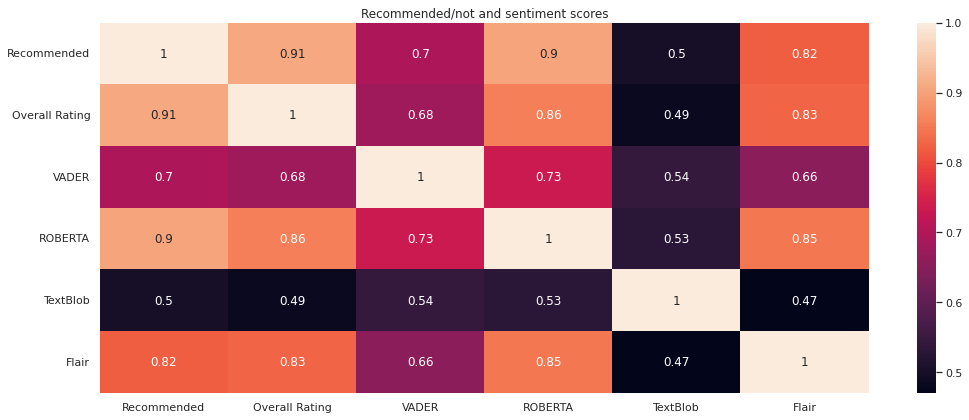

In [30]:
# Calculate the correlation between sentiments estimated using different methods
results_df['sentiment_tb_cat']=results_df['sentiment_tb'].astype('category').cat.codes
results_df['sentiment_vader_cat']=results_df['sentiment_vader'].astype('category').cat.codes
results_df['sentiment_rob_cat']=results_df['sentiment_rob'].astype('category').cat.codes
results_df['sentiment_flair_cat']=results_df['sentiment_flair'].astype('category').cat.codes
results_df['recommended_cat']=results_df['recommended'].astype('category').cat.codes


df_corr = results_df[['recommended_cat', 'overall_rating', "sentiment_vader_cat", "sentiment_rob_cat", "sentiment_tb_cat", "sentiment_flair_cat"]]
correl = df_corr.corr()
labels=["Recommended","Overall Rating", "VADER", "ROBERTA", "TextBlob", "Flair"]
fig = plt.subplots(figsize = (15, 6))
sns.heatmap(correl, annot=True, xticklabels=labels, yticklabels=labels).set(title='Recommended/not and sentiment scores')
plt.tight_layout()
plt.show()



##### **References**
<a id="1">[1]</a> 
Code reference for TextBlob impl.: https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524#:~:text=TextBlob%20is%20a%20simple%20library,classifying%20negative%20and%20positive%20words.

<a id="2">[2]</a> 
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

<a id="3">[3]</a>
Code reference for VADER impl.: https://youtu.be/QpzMWQvxXWk?t=1086


<a id="4">[4]</a>
Code reference for RoBERTa impl.: https://youtu.be/QpzMWQvxXWk?t=1602

<a id="5">[5]</a>
Code reference for Flair impl.: https://pub.towardsai.net/sentiment-analysis-without-modeling-textblob-vs-vader-vs-flair-657b7af855f4